# COVID-19 Classification and Detection Challenge

Part 2: Using Deep Learning for Classification and Class Activation Map (CAM) for Segmentation

Developed by:

**Ahmed Gouda, MAIA**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install barbar
import os
import shutil
import random
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import datasets, models, transforms
from barbar import Bar
import sys

sys.path.insert(1, '/content/drive/MyDrive/Colab Notebooks/COVID Challange/') # Import py files in the folder


# Configure parameters

In [ ]:
INPUT_SIZE = 512
BATCH_SIZE = 4
LEARNING_RATE=1e-4
NUM_EPOCHS = 20
NORM_TYPE = "mean_std"; #["min_max", "mean_std"]
NUM_CLASSES = 2

'''
'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152'
'''
MODEL_NAME = 'resnet18_trial' 

# Load the Dataset
The provided dataset of this challange comprises of 200 scans for normal cases, and 184 for Abnormal cases. The dataset for the both cases are divided into fixed portion of training and validation subset, and using a fixed random seed, as shown in the following table:

|  | Training | Validation |
| --- | --- | --- |
| Normal | 175 | 25 |
| Abnormal | 161 | 23 |
| Total | 336 | 48 |

The images are loaded from the 'modified' directory which are generated from the script `part1_preprocessing.ipynb`. This code calculates the average of 3 image channels into 1 channel, and rescales the intensties between 0 and 255. Then, it padding the images into a square dimentions. Finaly, it renames and saves the output image files.

## Load files

In [ ]:
# 'neg' represents the Normal scans, and 'pos' represents the Abnormal scans.
neg_dir = '/content/drive/MyDrive/Colab Notebooks/COVID Challange/modified/normal/'
pos_dir = '/content/drive/MyDrive/Colab Notebooks/COVID Challange/modified/abnormal/'

neg_files = os.listdir(neg_dir)
neg_files.sort()
pos_files = os.listdir(pos_dir)
pos_files.sort()

# Generate a fixed seed.
random.seed(0)

# Split the dataset.
val_neg_files = random.sample(neg_files, 25)
val_neg_files.sort()
val_pos_files = random.sample(pos_files, 23)
val_pos_files.sort()

train_neg_files = [file_scan for file_scan in neg_files if file_scan not in val_neg_files]
train_pos_files = [file_scan for file_scan in pos_files if file_scan not in val_pos_files]

# DataLoader

The data loader class `lung_scan_data` reads the dataset from the drive memory, applys images labeling according to the class, and appling preprocessing.





In [ ]:
#Transformation parameters for the training set by resizing the image into fixed size, and applying a random rotation by 30 degree.
data_transform_train = transforms.Compose([
    transforms.Resize(INPUT_SIZE, interpolation=Image.BILINEAR),
    transforms.RandomRotation(30, resample=Image.BILINEAR),
    transforms.ToTensor()
])

#Transformation parameters for the validation set by resizing the image into fixed size
data_transform_val = transforms.Compose([
    transforms.Resize(INPUT_SIZE, interpolation=Image.BILINEAR),
    transforms.ToTensor()
])

'''
The lung_scan_data characterize the key features of the dataset generate using through the following five inputs.
imgs_dir: The main root directory of the image.
imgs_files: The dataset files names.
label: The dataset label classes (0 for Normal and 1 for Abnormal).
transforms: Transformation function for preprocessing and data augmentation.
norm_type:  Normalization type ('min_max' or 'mean_std').
'''

class lung_scan_data(Dataset):
    def __init__(self, imgs_dir, imgs_files, label, transforms = None, norm_type = None):
        super().__init__()
        self.imgs_dir = imgs_dir
        self.imgs_files = imgs_files
        self.label = label
        self.transforms = transforms
        self.norm_type = norm_type

    def __len__(self):
        return len(self.imgs_files)
        
    def __getitem__(self, idx):
        
        image_name = self.imgs_dir + self.imgs_files[idx]
        img = Image.open(image_name)

        img_pix = np.array(img)
        img_pix = img_pix / 255.0

        ### Apply Transforms on image
        img = self.transforms(img) 
        img = img.numpy()
        img = img.astype('float32')

        # Apply Normalization
        if self.norm_type == 'mean_std':
          #Use the mean and std values of the original image img_pix before the transformation.
          img = img - img_pix.mean()
          img = img / img_pix.std()

        elif self.norm_type == 'min_max':
          img_min = abs(img.min())
          img_max = img.max()
          if img.min() < 0:
              img = img + img_min
              img = img / (img_max + img_min)
          else:
              img = (img - img_min) / (img_max-img_min)

        return img , self.label
    
# Create a data generator for the training set (0 for Normal and 1 for Abnormal)
train_dataset_neg = lung_scan_data(neg_dir, train_neg_files, 0, transforms = data_transform_train, norm_type = NORM_TYPE)
train_dataset_pos = lung_scan_data(pos_dir, train_pos_files, 1, transforms = data_transform_train, norm_type = NORM_TYPE)

# Create a data generator for the validation set (0 for Normal and 1 for Abnormal)
val_dataset_neg = lung_scan_data(neg_dir, val_neg_files, 0, transforms = data_transform_val, norm_type = NORM_TYPE)
val_dataset_pos = lung_scan_data(pos_dir, val_pos_files, 1, transforms = data_transform_val, norm_type = NORM_TYPE)

# Concatenate the generators into train_dataset and val_dataset.
train_dataset = ConcatDataset([train_dataset_neg, train_dataset_pos])
val_dataset = ConcatDataset([val_dataset_neg, val_dataset_pos])

# Creating the dataloader.
train_data_loader = DataLoader(dataset = train_dataset, num_workers = 4, batch_size = BATCH_SIZE, shuffle = True)
val_data_loader = DataLoader(dataset = val_dataset, num_workers = 4, batch_size = BATCH_SIZE, shuffle = False)        


In [ ]:
# Optional: Showing the train_data_loader output.
'''
for images, labels in train_data_loader:

  fig, axs = plt.subplots(1,images.shape[0], figsize=(15, 6))

  print(labels)

  axs = axs.ravel()
  for i in range (images.shape[0]):
    axs[i].imshow(images[i,0,:,:], cmap = 'gray')
    axs[i].set_title(str(i+1))

    print(np.max(images[i,0,:,:].numpy()))
    print(np.min(images[i,0,:,:].numpy()))

  plt.show()
  '''

"\nfor images, labels in train_data_loader:\n\n  fig, axs = plt.subplots(1,images.shape[0], figsize=(15, 6))\n\n  print(labels)\n\n  axs = axs.ravel()\n  for i in range (images.shape[0]):\n    axs[i].imshow(images[i,0,:,:], cmap = 'gray')\n    axs[i].set_title(str(i+1))\n\n    print(np.max(images[i,0,:,:].numpy()))\n    print(np.min(images[i,0,:,:].numpy()))\n\n  plt.show()\n  "

In [ ]:
# Optional: Showing the val_data_loader output
'''
for images, labels in val_data_loader:

  fig, axs = plt.subplots(1,images.shape[0], figsize=(15, 6))

  print(labels)

  axs = axs.ravel()
  for i in range (images.shape[0]):
    axs[i].imshow(images[i,0,:,:], cmap = 'gray')
    axs[i].set_title(str(i+1))

    print(np.max(images[i,0,:,:].numpy()))

  plt.show()
'''

"\nfor images, labels in val_data_loader:\n\n  fig, axs = plt.subplots(1,images.shape[0], figsize=(15, 6))\n\n  print(labels)\n\n  axs = axs.ravel()\n  for i in range (images.shape[0]):\n    axs[i].imshow(images[i,0,:,:], cmap = 'gray')\n    axs[i].set_title(str(i+1))\n\n    print(np.max(images[i,0,:,:].numpy()))\n\n  plt.show()\n"

In [ ]:
'''
for images, labels in val_data_loader:

  fig, axs = plt.subplots(1,images.shape[0], figsize=(15, 6))

  print(labels)

  axs = axs.ravel()
  for i in range (images.shape[0]):
    axs[i].imshow(images[i,0,:,:], cmap = 'gray')
    axs[i].set_title(str(i+1))

    print(np.max(images[i,0,:,:].numpy()))

  plt.show()

'''

"\nfor images, labels in val_data_loader:\n\n  fig, axs = plt.subplots(1,images.shape[0], figsize=(15, 6))\n\n  print(labels)\n\n  axs = axs.ravel()\n  for i in range (images.shape[0]):\n    axs[i].imshow(images[i,0,:,:], cmap = 'gray')\n    axs[i].set_title(str(i+1))\n\n    print(np.max(images[i,0,:,:].numpy()))\n\n  plt.show()\n\n"

# Load the Model

The PyTorch models package are configures with 3 input channels. Moreover, it allows to use pretrained models on Imagenet for transfere learning. However, our data scans comprises of a single gray level channel. We can overcome this problem through two different solutions. 

*   The **first solution** by ruplicating the single channel into 3 channels, and using utilize the benefits of using ImageNet transfere learning.
*   The **second solution** by reconfigure the original Pytorch models (From the link: https://github.com/pytorch/vision/tree/master/torchvision/models) into a single channel to optimize the GPU memory.

In this script, I applied the **second solution**.

## Initialize the network

In [ ]:
import torch.nn as nn
from resnet_model import resnet18, resnet34, resnet50, resnet101, resnet152
from torchsummary import summary

def set_parameter_requires_grad(model, feature_extracting):
    """
     
    This helper function sets the ``.requires_grad`` attribute of the
    parameters in the model to False when we are feature extracting. By
    default, when we load a pretrained model all of the parameters have
    ``.requires_grad=True``, which is fine if we are training from scratch
    or finetuning. However, if we are feature extracting and only want to
    compute gradients for the newly initialized layer then we want all of
    the other parameters to not require gradients. This will make more sense
    later.
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
FEATURE_EXTRACT= False

# Initialize the model for this run

'''
'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152'
'''
MODEL_NAME = 'resnet152'
if MODEL_NAME == 'resnet18_trial':
  model_ft = resnet18()
elif MODEL_NAME == 'resnet34':
  model_ft = resnet34()
elif MODEL_NAME == 'resnet50':
  model_ft = resnet50()
elif MODEL_NAME == 'resnet101':
  model_ft = resnet101()
elif MODEL_NAME == 'resnet152':
  model_ft = resnet152()

set_parameter_requires_grad(model_ft, False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)

# Print the model we just instantiated
print(model_ft)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Send the model to GPU
model_ft = model_ft.to(device)

summary(model_ft, (1,INPUT_SIZE, INPUT_SIZE))

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Initialize the optimizer and the loss function

In [ ]:
import torch.optim as optim

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)

## Initialize the loss function
In our case we have unblanced training dataset, as the Normal datase comprises of 175 training cases the the Abnormal dataset comprises of 161 cases. Therefore, a weighted Cross Entropy loss function is used to overcome this problem.

*   The Normal case loss weight is $1 - \frac{175}{175+161} = 0.48$  
*   The Abnormal case loss weight is $1 - \frac{161}{175+161} = 0.52$ 






In [ ]:
# Setup the loss fxn
weights = [0.48, 0.52]
class_weights = torch.FloatTensor(weights).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the Model

In [ ]:
'''
Create folders to save the model weights at each epoch and the best model wegiht.
'''
model_dir = '/content/drive/MyDrive/Colab Notebooks/COVID Challange/models_weights/'

## Remove the previos saved weights.
try:
    shutil.rmtree(model_dir + MODEL_NAME)
except OSError as e:
    pass
else:
    print ("Deleted the saved weights.")

#Create new directories to save the new weights.
try:
    os.mkdir(model_dir + MODEL_NAME)
    os.mkdir(model_dir + MODEL_NAME + '/all_models')
    os.mkdir(model_dir + MODEL_NAME + '/best_model')
except OSError:
    print ("Creation of the directory failed.")
else:
    print ("Successfully created the directory.")


Deleted the saved weights.
Successfully created the directory.


In [ ]:
"""
This code section preforms training and validation using the initialized model, loss function, an optimizer.
The function trains for the specified number of epochs and after each
epoch runs a full validation step. It also keeps track of the best
performing model (in terms of validation accuracy), and at the end of
training returns the best performing model. After each epoch, the
training and validation accuracies are printed, and all models and the best model are saved.
"""
training_metrics=np.zeros((NUM_EPOCHS,4))
best_train_acc = 0.0
best_val_acc = 0.0

for epoch in range(NUM_EPOCHS):
    print('Epoch {}/{}'.format(epoch+1, NUM_EPOCHS))
    print('-' * 10)

    # -----------------------------
    # Training stage
    # -----------------------------
    model_ft.train() 
    train_running_loss = 0.0
    train_running_corrects = 0
    train_total_len=0

    # Iterate over data.
    for inputs, labels in Bar(train_data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer_ft.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(True):
            # Get model outputs and calculate loss    
            outputs = model_ft(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            train_total_len+=len(preds)
            # backward + optimize only if in training phase
            loss.backward()
            optimizer_ft.step()

        # statistics
        train_running_loss += loss.item() * inputs.size(0)
        train_running_corrects += torch.sum(preds == labels.data)

    train_epoch_loss = train_running_loss / train_total_len
    train_epoch_acc = train_running_corrects.double() / train_total_len

    # -----------------------------
    # Validation stage
    # -----------------------------
    model_ft.eval()   # Set model to evaluate mode

    val_running_loss = 0.0
    val_running_corrects = 0
    val_total_len=0
    # Iterate over data.
    for inputs, labels in Bar(val_data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer_ft.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model_ft(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_total_len+=len(preds)

        # statistics
        val_running_loss += loss.item() * inputs.size(0)
        val_running_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_running_loss / val_total_len
    val_epoch_acc = val_running_corrects.double() / val_total_len

    print('Epoch {:d}: train_loss {:.4f} train_acc {:.4f} val_loss {:.4f} val_acc {:.4f}'.format(
        epoch + 1, 
        train_epoch_loss, 
        train_epoch_acc,
        val_epoch_loss,
        val_epoch_acc))
    
    training_metrics[epoch,[0,1,2,3]]=[train_epoch_loss, train_epoch_acc, val_epoch_loss, val_epoch_acc]

    #Save the model which has the bes validation accuracy, followed by the best training accuracy.
    torch.save(model_ft.state_dict(), model_dir + MODEL_NAME + '/all_models/model_' + str(epoch+1) + '.pt')
    if best_val_acc < val_epoch_acc:
      best_val_acc = val_epoch_acc
      torch.save(model_ft.state_dict(), model_dir + MODEL_NAME + '/best_model/best_model.pt')
      print('Save the weights for the highest validation accuracy.')
    #If the best validation accuracy and the current validation accuracy are equal, check the best training accuracy.
    elif best_val_acc == val_epoch_acc:
      if best_train_acc < train_epoch_acc:
        torch.save(model_ft.state_dict(), model_dir + MODEL_NAME + '/best_model/best_model.pt')
        print('Save the weights for the highest training and validation accuracy.')
    if best_train_acc < train_epoch_acc:
      best_train_acc = train_epoch_acc


Epoch 1/20
----------
336/336: [===============================>] - ETA 1.4s
48/48: [=============================>..] - ETA 1.3s
Epoch 1: train_loss 0.3450 train_acc 0.8690 val_loss 1.8915 val_acc 0.5833
Save the weights for the highest validation accuracy.
Epoch 2/20
----------
336/336: [===============================>] - ETA 0.8s
48/48: [=============================>..] - ETA 0.7s
Epoch 2: train_loss 0.2282 train_acc 0.9196 val_loss 0.0130 val_acc 1.0000
Save the weights for the highest validation accuracy.
Epoch 3/20
----------
336/336: [===============================>] - ETA 1.2s
48/48: [=============================>..] - ETA 0.6s
Epoch 3: train_loss 0.1812 train_acc 0.9286 val_loss 0.0160 val_acc 1.0000
Save the weights for the highest training and validation accuracy.
Epoch 4/20
----------
336/336: [===============================>] - ETA 0.7s
48/48: [=============================>..] - ETA 0.9s
Epoch 4: train_loss 0.0954 train_acc 0.9673 val_loss 0.0120 val_acc 1.0000
Save 

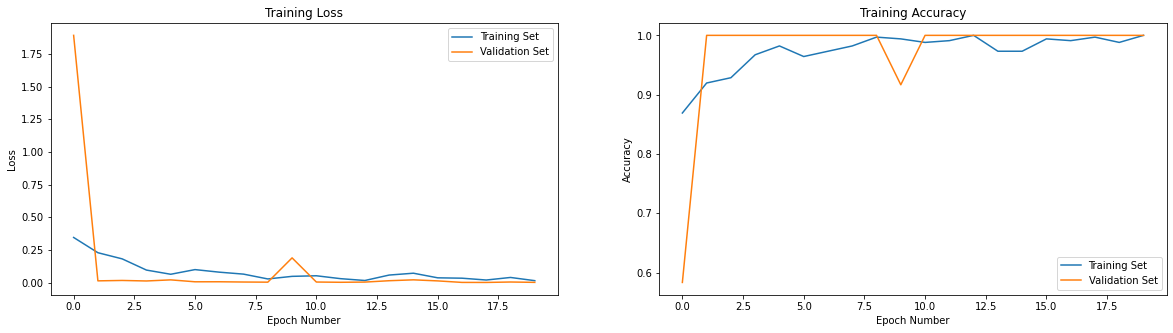

In [ ]:
#Plot the training loss and accuracy values at each epoch
fig=plt.figure(figsize=(20, 5))
fig.add_subplot(1, 2, 1)
plt.plot(training_metrics[:,[0,2]])
plt.legend(["Training Set","Validation Set"])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.title('Training Loss') 
fig.add_subplot(1, 2, 2)
plt.plot(training_metrics[:,[1,3]])
plt.legend(["Training Set","Validation Set"])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.title('Training Accuracy') 
plt.show()

# Geneating the Activation Maps and Abnormal Reigons Segmentation

## Load the best model
Loading the best training model weights which porovided the higest validation accuracy.

In [ ]:
model_dir = '/content/drive/MyDrive/Colab Notebooks/COVID Challange/models_weights/'

# Model class must be defined somewhere
if MODEL_NAME == 'resnet18_trial':
  best_model_ft = resnet18()
elif MODEL_NAME == 'resnet34':
  best_model_ft = resnet34()
elif MODEL_NAME == 'resnet50':
  best_model_ft = resnet50()
elif MODEL_NAME == 'resnet101':
  best_model_ft = resnet101()
elif MODEL_NAME == 'resnet152':
  best_model_ft = resnet152()
  
set_parameter_requires_grad(best_model_ft, FEATURE_EXTRACT)
num_ftrs = best_model_ft.fc.in_features
best_model_ft.fc = nn.Linear(num_ftrs, 2)

# Define the torch.device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_model_ft.to(device)
best_model_ft.load_state_dict(torch.load(model_dir + 'resnet18' + '/best_model/best_model.pt'))
best_model_ft.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

The following `getCAM` function, reads 3 parameters which are `feature_conv`, `weight`, and `class_idx`. `feature_conv` represents the feature map of the last convolutional layer, the `weights` is the ectracted trained weights of the fully connected layer, and `class_idx` represents the predicted class label.

In [ ]:
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import skimage.transform

class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    print(nc)
    print(h)
    print(w)
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    dummy = feature_conv.reshape((nc, h*w))
    print(cam.shape)
    print(dummy.shape)
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]



## Normal validation cases

The validation images are read from the folder and preprocessed. Then the are sent to the model to the model to calculate the predicted logits. In this case logit shape is `torch.size([1,c])`, where `c` represents number of classes. Then, Softmax function `F.softmax(logit, dim=1).data.squeeze()` is applied to convert the shape to `torch.size([c])`, and to calculate the prediction probabilities. The feature map of the last convolutional layer of the ResNet model, the weights that have been extracted from the trained parameters. Then, the `getCAM` function calculates the Activation Map using the extracted model parameters and the predicted class type. Finally, the output activation map are resized to fit the fit the validation image dimension and to show the activation regions.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Predicted class for image 1: 0
512
16
16
(256,)
(512, 256)


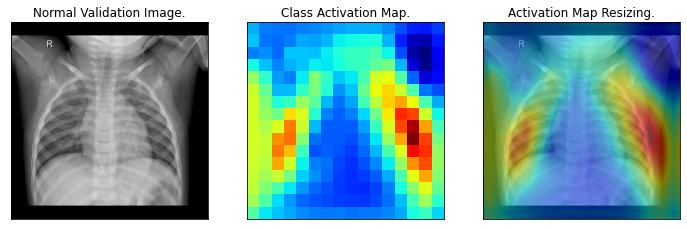

In [ ]:
TN = 0
for idx, scan_name in enumerate(val_neg_files[0:1]):
  img = Image.open(neg_dir + scan_name)
  img_pix = np.array(img)
  img_pix = img_pix / 255.0

  ### Apply Transforms on image
  img = data_transform_val(img)
  img = img.numpy()
  img = img.astype('float32')

  # Apply Normalization
  if NORM_TYPE == 'mean_std':
    img = img - img_pix.mean()
    img = img / img_pix.std()

  elif NORM_TYPE == 'min_max':
    img_min = abs(img.min())
    img_max = img.max()
    if img.min() < 0:
        img = img + img_min
        img = img / (img_max + img_min)
    else:
        img = (img - img_min) / (img_max-img_min)

  #Converting the preprocessed image into tensor and sending it to the GPU
  img_tensor = torch.from_numpy(img)
  prediction_var = Variable((img_tensor.unsqueeze(0)).cuda(), requires_grad=True)

  #Extracting the features of the last convolutional layer for the ResNet model 
  final_layer = best_model_ft._modules.get('layer4')
  activated_features = SaveFeatures(final_layer)

  #Extracting the fully conncted training parameters weights
  weight_softmax_params = list(best_model_ft._modules.get('fc').parameters())
  weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

  #Predicting the image class
  prediction = best_model_ft(prediction_var)
  pred_probabilities = F.softmax(prediction).data.squeeze()
  class_idx = topk(pred_probabilities,1)[1].int()
  
  print('Predicted class for image '+ str(idx+1) + ': ' + str(class_idx.cpu().numpy()[0]))
  if class_idx.cpu().numpy()[0] == 0:
    TN +=1
  
  #Calculating the activation map
  overlay = getCAM(activated_features.features, weight_softmax, class_idx )

  #Resize the acativation map to fit the image size
  heat_map = skimage.transform.resize(overlay[0], img.shape[1:3])
  
  plt.figure(figsize=(12, 12))
  plt.subplot(131),plt.imshow(img_tensor[0,:,:],cmap = 'gray')
  plt.title('Normal Validation Image.'), plt.xticks([]), plt.yticks([])
  plt.subplot(132),plt.imshow(overlay[0], cmap='jet')
  plt.title('Class Activation Map.'), plt.xticks([]), plt.yticks([])
  plt.subplot(133)
  plt.imshow(img[0,:,:],cmap = 'gray')
  plt.imshow(heat_map, alpha=0.5, cmap='jet');
  plt.title('Activation Map Resizing.'), plt.xticks([]), plt.yticks([])
  plt.show()

FN = len(val_neg_files) - TN

## Abnormal validation cases

The same previous steps are applied to obtain the Activation Map for the abnormal casses, but an additional step is preformed to segment the regions of abnormality. 

In [ ]:
TP = 0   #True Positive variable
for idx, scan_name in enumerate(val_pos_files):
  img = Image.open(pos_dir + scan_name)
  img_pix = np.array(img)
  img_pix = img_pix / 255.0

  ### Apply Transforms on image
  img = data_transform_val(img)
  img = img.numpy()
  img = img.astype('float32')

  # Apply Normalization
  if NORM_TYPE == 'mean_std':
    img = img - img_pix.mean()
    img = img / img_pix.std()

  elif NORM_TYPE == 'min_max':
    img_min = abs(img.min())
    img_max = img.max()
    if img.min() < 0:
        img = img + img_min
        img = img / (img_max + img_min)
    else:
        img = (img - img_min) / (img_max-img_min)

  #Converting the preprocessed image into tensor and sending it to the GPU
  img_tensor = torch.from_numpy(img)
  prediction_var = Variable((img_tensor.unsqueeze(0)).cuda(), requires_grad=True)

  #Extracting the features of the last convolutional layer for the ResNet model 
  final_layer = best_model_ft._modules.get('layer4')
  activated_features = SaveFeatures(final_layer)
  print(final_layer)

  #Extracting the training parameters weights
  weight_softmax_params = list(best_model_ft._modules.get('fc').parameters())
  weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

  #Predicting the image class 
  prediction = best_model_ft(prediction_var)
  pred_probabilities = F.softmax(prediction).data.squeeze()
  class_idx = topk(pred_probabilities,1)[1].int()
  
  print('Predicted class for image '+ str(idx+1) + ': ' + str(class_idx.cpu().numpy()[0]))
  if class_idx.cpu().numpy()[0] == 1:
    TP +=1
  
  #Calculating the activation map
  overlay = getCAM(activated_features.features, weight_softmax, class_idx )

  #Resize the acativation map to fit the image size
  heat_map = skimage.transform.resize(overlay[0], img.shape[1:3])

  #Hard segmenting the predicted heat map of the Abnormal reigons using an arbitrary threshold 0.85
  heat_map_mask = np.zeros(heat_map.shape, dtype=int)
  heat_map_mask[heat_map>0.85] = 1;

  #plot the results
  plt.figure(figsize=(20, 20))
  plt.subplot(151),plt.imshow(img_tensor[0,:,:],cmap = 'gray')
  plt.title('Abnormal Validation Image.'), plt.xticks([]), plt.yticks([])
  plt.subplot(152),plt.imshow(overlay[0], cmap='jet')
  plt.title('Class Activation Map.'), plt.xticks([]), plt.yticks([])
  plt.subplot(153)
  plt.imshow(img[0,:,:],cmap = 'gray')
  plt.imshow(heat_map, alpha=0.5, cmap='jet');
  plt.title('Activation Map Resizing.'), plt.xticks([]), plt.yticks([])
  plt.subplot(154)
  plt.imshow(heat_map_mask,cmap = 'gray')
  plt.title('Segmentation Mask.'), plt.xticks([]), plt.yticks([])
  plt.show()

FP = len(val_pos_files) - TP

Output hidden; open in https://colab.research.google.com to view.

# Evaluate the Model

This section evaluates predicted classes of the validation set using the following metric fuctions:

*   Accuracy
*   Senstivity(Recall)
*   Specifity
*   Precision
*   F1 Score   



In [ ]:
accuracy = (TP + TN) / (TP + FP + TN + FN)
senstivity = TP / (TP + FN) 
specifity = TN / (TN + FP)
precision = TP / (TP + FP)
f1 = 2*(precision * senstivity)/(precision + senstivity)

print("True Positive(TP): " + str(TP))
print("False Positive(FP): " + str(FP))
print("True Negative(TN): " + str(TN))
print("False Negative(FN): " + str(FN))
print("Accuracy: " + str(accuracy))
print("Senstivity(Recall): " + str(senstivity))
print("Specifity: " + str(specifity))
print("Precision: " + str(precision))
print("F1 Score: " + str(f1))

True Positive(TP): 23
False Positive(FP): 0
True Negative(TN): 25
False Negative(FN): 0
Accuracy: 1.0
Senstivity(Recall): 1.0
Specifity: 1.0
Precision: 1.0
F1 Score: 1.0
